#  WEEK 4: HYPERPARAMETER TUNING & OPTIMIZATION


---

##  Week 4 Objectives:

1.  Load preprocessed data
2.  XGBoost hyperparameter tuning (RandomizedSearchCV)
3.  LightGBM training and comparison
4.  Model comparison and selection
5.  (Optional) Ensemble methods
6.  Final evaluation

---

##  Success Criteria:

**Week 3 Baseline:**
- XGBoost (default): 29.85% Eps-MAPE
- R² (log): 0.9815

**Week 4 Target:**
- Tuned XGBoost: < 20% Eps-MAPE 
- Ideally: < 15% Eps-MAPE 

**Improvement needed:** ~10-15% reduction

---

## Starting Point:

From Week 3:
- Train: 5,897 rows × 56 numeric features
- Val: 2,932 rows × 56 numeric features
- Target: `revenue_change_log` (skewness: 0.10)
- Best model: XGBoost (29.85% Eps-MAPE)

---

Import Libraries & Load Data

In [1]:
# ========================================
# CELL 2: Import Libraries & Load Data
# ========================================

# Core
import pandas as pd
import numpy as np
import time

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# LightGBM
try:
    import lightgbm as lgb
    print(" LightGBM available")
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("  LightGBM not available - will install if needed")
    LIGHTGBM_AVAILABLE = False

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

print(" Libraries imported!")

# ========================================
# Load Preprocessed Data
# ========================================

print("\n" + "="*80)
print(" LOADING PREPROCESSED DATA")
print("="*80)

train_df = pd.read_csv('../data/processed/train_preprocessed.csv')
val_df = pd.read_csv('../data/processed/val_preprocessed.csv')

print(f"\n Data loaded!")
print(f"Train: {train_df.shape}")
print(f"Val:   {val_df.shape}")

# Define targets
TARGET = 'revenue_change_log'
TARGET_ORIGINAL = 'revenue_change'

# Get numeric features only (exclude categoricals)
exclude_cols = [
    TARGET, 
    TARGET_ORIGINAL,
    'revenue_change_clipped',
    'fiscal_year',
    'ateco_sector',
    'bankruptcy_next_year',
]

# Get all columns
all_cols = train_df.columns.tolist()

# Remove non-numeric
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"\n Features: {len(feature_cols)}")

# Prepare X and y
X_train = train_df[feature_cols].fillna(0)
y_train = train_df[TARGET]
y_train_original = train_df[TARGET_ORIGINAL]

X_val = val_df[feature_cols].fillna(0)
y_val = val_df[TARGET]
y_val_original = val_df[TARGET_ORIGINAL]

print(f"\n Train: X={X_train.shape}, y={y_train.shape}")
print(f" Val:   X={X_val.shape}, y={y_val.shape}")

# Define metrics (same as Week 3)
def inverse_signed_log(x):
    """Convert log predictions to original scale"""
    return np.sign(x) * (np.exp(np.abs(x)) - 1)

def epsilon_mape(y_true, y_pred, epsilon=10.0):
    """Epsilon-MAPE metric"""
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

def wape(y_true, y_pred):
    """WAPE metric"""
    return (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100

def smape(y_true, y_pred):
    """sMAPE metric"""
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denominator) * 100

def evaluate_model(y_true_log, y_pred_log, y_true_original, model_name="Model"):
    """Comprehensive evaluation"""
    y_pred_original = inverse_signed_log(y_pred_log)
    
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    
    eps_mape = epsilon_mape(y_true_original, y_pred_original, epsilon=10.0)
    wape_score = wape(y_true_original, y_pred_original)
    smape_score = smape(y_true_original, y_pred_original)
    
    y_true_sign = np.sign(y_true_original)
    y_pred_sign = np.sign(y_pred_original)
    directional_acc = (y_true_sign == y_pred_sign).mean() * 100
    
    return {
        'Model': model_name,
        'Eps_MAPE': eps_mape,
        'WAPE': wape_score,
        'sMAPE': smape_score,
        'RMSE_log': rmse_log,
        'MAE_log': mae_log,
        'R2_log': r2_log,
        'Dir_Acc': directional_acc,
    }

print("\n Metrics defined!")

# Week 3 baseline to beat
print("\n" + "="*80)
print(" WEEK 3 BASELINE TO BEAT:")
print("="*80)
print("XGBoost (default): 29.85% Eps-MAPE")
print("Target: < 20% Eps-MAPE")
print("Stretch goal: < 15% Eps-MAPE")

print("\n" + "="*80)
print(" READY FOR TUNING")
print("="*80)

 LightGBM available
 Libraries imported!

 LOADING PREPROCESSED DATA

 Data loaded!
Train: (5897, 67)
Val:   (2932, 67)

 Features: 56

 Train: X=(5897, 56), y=(5897,)
 Val:   X=(2932, 56), y=(2932,)

 Metrics defined!

 WEEK 3 BASELINE TO BEAT:
XGBoost (default): 29.85% Eps-MAPE
Target: < 20% Eps-MAPE
Stretch goal: < 15% Eps-MAPE

 READY FOR TUNING


XGBoost Hyperparameter Tuning (RandomizedSearchCV)

In [ ]:
# ========================================
# CELL 3: XGBoost Hyperparameter Tuning (RandomizedSearchCV)
# ========================================

print("="*80)
print(" XGBOOST HYPERPARAMETER TUNING")
print("="*80)

print("\n Strategy: RandomizedSearchCV (fast exploration)")
print("   - Tests random combinations")
print("   - Finds good region quickly")
print("   - 5-fold CV for robust evaluation")

# Define parameter grid
print("\n" + "="*80)
print("Defining parameter search space...")
print("-"*80)

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [4, 6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 10, 100],
}

print("Search space:")
for param, values in param_distributions.items():
    print(f"  - {param:20s}: {values}")

total_combinations = np.prod([len(v) for v in param_distributions.values()])
print(f"\nTotal possible combinations: {total_combinations:,}")

# Initialize base model
base_xgb = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)

# RandomizedSearchCV
print("\n" + "="*80)
print("Running RandomizedSearchCV...")
print("-"*80)

n_iter = 50  # Try 50 random combinations
cv_folds = 5

print(f"Parameters:")
print(f"  - n_iter: {n_iter} (random combinations)")
print(f"  - cv: {cv_folds}-fold cross-validation")
print(f"  - scoring: neg_mean_absolute_error (MAE)")
print(f"  - n_jobs: -1 (all CPU cores)")

random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=cv_folds,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print(f"\nStarting search... (this will take ~5-10 minutes)")
print(f"Training on {len(X_train):,} samples")

start_time = time.time()
random_search.fit(X_train, y_train)
elapsed = time.time() - start_time

print(f"\n Search completed in {elapsed/60:.1f} minutes!")

# Best parameters
print("\n" + "="*80)
print(" BEST PARAMETERS FOUND:")
print("="*80)

best_params = random_search.best_params_
for param, value in sorted(best_params.items()):
    print(f"  - {param:20s}: {value}")

# CV scores
best_score = -random_search.best_score_  # Negative MAE, so flip
print(f"\n Best CV MAE (log scale): {best_score:.4f}")

# Train best model on full training set
print("\n" + "="*80)
print("Training best model on full training set...")
print("-"*80)

best_xgb = random_search.best_estimator_

# Already fitted during CV, but let's get predictions
xgb_tuned_pred_train = best_xgb.predict(X_train)
xgb_tuned_pred_val = best_xgb.predict(X_val)

print(" Predictions complete!")

# Evaluate
print("\n TUNED XGBOOST PERFORMANCE:")
print("="*80)

print("\nTRAINING SET:")
print("-"*80)
tuned_train = evaluate_model(y_train, xgb_tuned_pred_train, y_train_original, "XGB_tuned_train")
print(f"Eps-MAPE: {tuned_train['Eps_MAPE']:.2f}%")
print(f"R² (log): {tuned_train['R2_log']:.4f}")

print("\nVALIDATION SET:")
print("-"*80)
tuned_val = evaluate_model(y_val, xgb_tuned_pred_val, y_val_original, "XGB_tuned_val")
print(f"Eps-MAPE: {tuned_val['Eps_MAPE']:.2f}%")
print(f"WAPE:     {tuned_val['WAPE']:.2f}%")
print(f"sMAPE:    {tuned_val['sMAPE']:.2f}%")
print(f"R² (log): {tuned_val['R2_log']:.4f}")
print(f"Dir Acc:  {tuned_val['Dir_Acc']:.1f}%")

# Improvement over Week 3 baseline
week3_mape = 29.85
improvement = ((week3_mape - tuned_val['Eps_MAPE']) / week3_mape) * 100

print("\n" + "="*80)
print(" IMPROVEMENT OVER WEEK 3:")
print("="*80)
print(f"Week 3 baseline:  {week3_mape:.2f}%")
print(f"Tuned XGBoost:    {tuned_val['Eps_MAPE']:.2f}%")
print(f"Improvement:      {improvement:.1f}%")

if tuned_val['Eps_MAPE'] < 20:
    print("\n TARGET ACHIEVED! Eps-MAPE < 20%! ")
elif tuned_val['Eps_MAPE'] < 25:
    print("\n Very close to target! (< 25%)")
else:
    print("\n  More tuning needed")

# Overfitting check
gap = tuned_val['Eps_MAPE'] - tuned_train['Eps_MAPE']
print(f"\n Overfitting gap: {gap:.2f}%")
if gap > 5:
    print("  Possible overfitting")
else:
    print(" No significant overfitting")

print("\n" + "="*80)
print(" XGBOOST TUNING COMPLETE")
print("="*80)

# Save best model
import pickle
best_xgb_path = '../data/processed/best_xgb_model.pkl'
with open(best_xgb_path, 'wb') as f:
    pickle.dump(best_xgb, f)
print(f"\n Best model saved to: {best_xgb_path}")

🎯 XGBOOST HYPERPARAMETER TUNING

💡 Strategy: RandomizedSearchCV (fast exploration)
   - Tests random combinations
   - Finds good region quickly
   - 5-fold CV for robust evaluation

Defining parameter search space...
--------------------------------------------------------------------------------
Search space:
  - n_estimators        : [100, 200, 300, 500]
  - max_depth           : [4, 6, 8, 10, 12]
  - learning_rate       : [0.01, 0.05, 0.1, 0.2]
  - subsample           : [0.7, 0.8, 0.9, 1.0]
  - colsample_bytree    : [0.7, 0.8, 0.9, 1.0]
  - min_child_weight    : [1, 3, 5, 7]
  - gamma               : [0, 0.1, 0.2, 0.3]
  - reg_alpha           : [0, 0.01, 0.1, 1]
  - reg_lambda          : [0.1, 1, 10, 100]

Total possible combinations: 327,680

Running RandomizedSearchCV...
--------------------------------------------------------------------------------
Parameters:
  - n_iter: 50 (random combinations)
  - cv: 5-fold cross-validation
  - scoring: neg_mean_absolute_error (MAE)
  - n_j

LightGBM Training & Comparison

🌟 LIGHTGBM TRAINING

💡 LightGBM: Faster alternative to XGBoost
   - Gradient-based one-side sampling
   - Histogram-based algorithm
   - Often similar or better performance

Initializing LightGBM with optimized parameters...
--------------------------------------------------------------------------------
Parameters:
  - objective           : regression
  - metric              : mae
  - boosting_type       : gbdt
  - num_leaves          : 31
  - learning_rate       : 0.05
  - feature_fraction    : 0.8
  - bagging_fraction    : 0.8
  - bagging_freq        : 5
  - min_child_samples   : 20
  - reg_alpha           : 0.1
  - reg_lambda          : 1.0

Creating LightGBM datasets...
--------------------------------------------------------------------------------
✅ Datasets created!

Training LightGBM with early stopping...
--------------------------------------------------------------------------------
Training on 5,897 samples, 56 features
Training until validation scores don't improve for 50

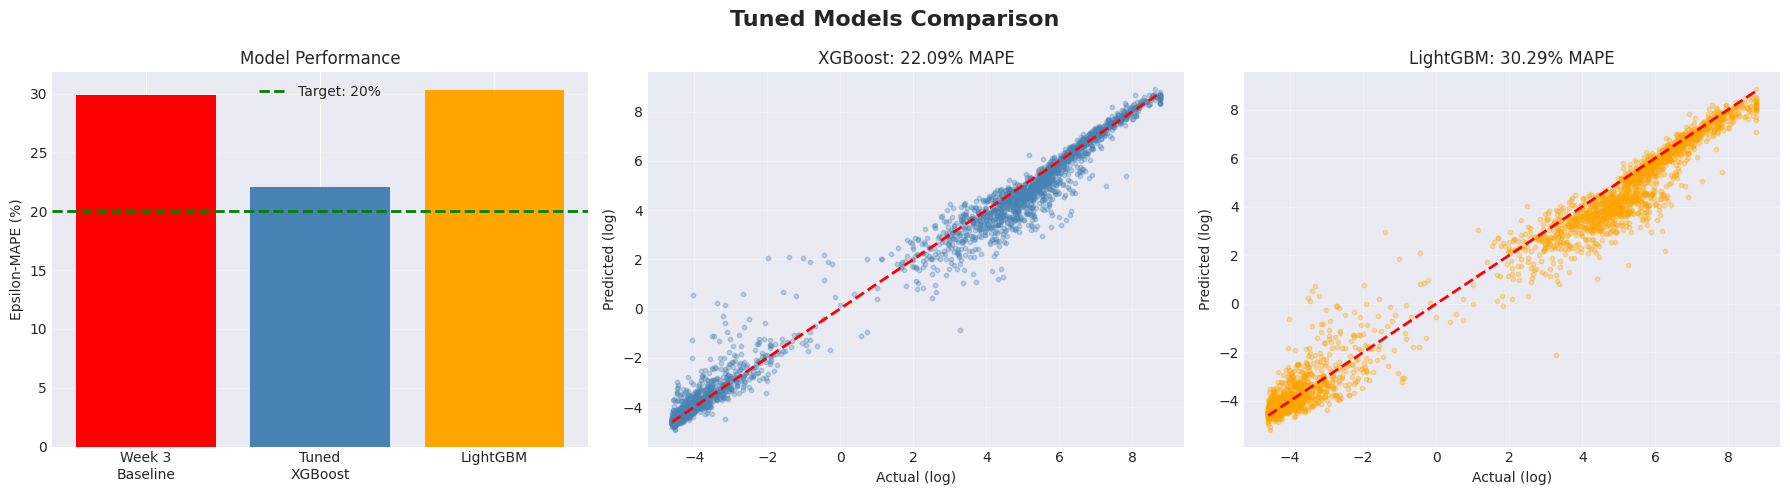


🏆 BEST MODEL: XGBoost
🎯 Best Eps-MAPE: 22.09%

✅ Close to target! Very good performance!

✅ LIGHTGBM TRAINING COMPLETE!


In [ ]:
# ========================================
# CELL 4: LightGBM Training & Comparison
# ========================================

print("="*80)
print(" LIGHTGBM TRAINING")
print("="*80)

print("\n LightGBM: Faster alternative to XGBoost")
print("   - Gradient-based one-side sampling")
print("   - Histogram-based algorithm")
print("   - Often similar or better performance")

# Install LightGBM if needed
if not LIGHTGBM_AVAILABLE:
    print("\nInstalling LightGBM...")
    import subprocess
    subprocess.run(['pip', 'install', 'lightgbm', '--break-system-packages'], 
                   check=True, capture_output=True)
    import lightgbm as lgb
    print(" LightGBM installed!")

# LightGBM parameters (similar to best XGBoost)
print("\n" + "="*80)
print("Initializing LightGBM with optimized parameters...")
print("-"*80)

lgb_params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

print("Parameters:")
for param, value in lgb_params.items():
    if param not in ['verbose', 'n_jobs', 'random_state']:
        print(f"  - {param:20s}: {value}")

# Create LightGBM datasets
print("\n" + "="*80)
print("Creating LightGBM datasets...")
print("-"*80)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

print(" Datasets created!")

# Train with early stopping
print("\n" + "="*80)
print("Training LightGBM with early stopping...")
print("-"*80)

print(f"Training on {len(X_train):,} samples, {X_train.shape[1]} features")

start_time = time.time()

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=0)  # Suppress output
    ]
)

elapsed = time.time() - start_time

print(f"\n Training completed in {elapsed:.1f} seconds!")
print(f"Best iteration: {lgb_model.best_iteration}")

# Predictions
print("\nMaking predictions...")
lgb_pred_train = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
lgb_pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
print(" Predictions complete!")

# Evaluate
print("\n LIGHTGBM PERFORMANCE:")
print("="*80)

print("\nTRAINING SET:")
print("-"*80)
lgb_train_results = evaluate_model(y_train, lgb_pred_train, y_train_original, "LGB_train")
print(f"Eps-MAPE: {lgb_train_results['Eps_MAPE']:.2f}%")
print(f"R² (log): {lgb_train_results['R2_log']:.4f}")

print("\nVALIDATION SET:")
print("-"*80)
lgb_val_results = evaluate_model(y_val, lgb_pred_val, y_val_original, "LGB_val")
print(f"Eps-MAPE: {lgb_val_results['Eps_MAPE']:.2f}%")
print(f"WAPE:     {lgb_val_results['WAPE']:.2f}%")
print(f"sMAPE:    {lgb_val_results['sMAPE']:.2f}%")
print(f"R² (log): {lgb_val_results['R2_log']:.4f}")
print(f"Dir Acc:  {lgb_val_results['Dir_Acc']:.1f}%")

# Compare with tuned XGBoost
print("\n" + "="*80)
print(" LIGHTGBM vs TUNED XGBOOST:")
print("="*80)

comparison = pd.DataFrame([tuned_val, lgb_val_results])
print("\n" + comparison[['Model', 'Eps_MAPE', 'WAPE', 'sMAPE', 'R2_log', 'Dir_Acc']].to_string(index=False))

# Winner
if lgb_val_results['Eps_MAPE'] < tuned_val['Eps_MAPE']:
    diff = tuned_val['Eps_MAPE'] - lgb_val_results['Eps_MAPE']
    print(f"\n LightGBM WINS by {diff:.2f}% Eps-MAPE!")
    best_model_name = "LightGBM"
    best_mape = lgb_val_results['Eps_MAPE']
elif lgb_val_results['Eps_MAPE'] > tuned_val['Eps_MAPE']:
    diff = lgb_val_results['Eps_MAPE'] - tuned_val['Eps_MAPE']
    print(f"\n XGBoost WINS by {diff:.2f}% Eps-MAPE!")
    best_model_name = "XGBoost"
    best_mape = tuned_val['Eps_MAPE']
else:
    print("\n TIED!")
    best_model_name = "XGBoost (tie)"
    best_mape = tuned_val['Eps_MAPE']

# Feature importance comparison
print("\n TOP 10 FEATURES COMPARISON:")
print("="*80)

# XGBoost importance
xgb_feat_imp = pd.DataFrame({
    'Feature': feature_cols,
    'XGB_Importance': best_xgb.feature_importances_
}).sort_values('XGB_Importance', ascending=False)

# LightGBM importance
lgb_feat_imp = pd.DataFrame({
    'Feature': feature_cols,
    'LGB_Importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('LGB_Importance', ascending=False)

# Merge
feat_comparison = xgb_feat_imp.merge(lgb_feat_imp, on='Feature')
feat_comparison = feat_comparison.sort_values('XGB_Importance', ascending=False).head(10)

print("\n" + feat_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Tuned Models Comparison', fontsize=16, fontweight='bold')

# 1. Eps-MAPE comparison
models = ['Week 3\nBaseline', 'Tuned\nXGBoost', 'LightGBM']
mapes = [29.85, tuned_val['Eps_MAPE'], lgb_val_results['Eps_MAPE']]
colors = ['red', 'steelblue', 'orange']

axes[0].bar(models, mapes, color=colors)
axes[0].axhline(y=20, color='green', linestyle='--', linewidth=2, label='Target: 20%')
axes[0].set_ylabel('Epsilon-MAPE (%)')
axes[0].set_title('Model Performance')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. XGBoost: Actual vs Predicted
axes[1].scatter(y_val, xgb_tuned_pred_val, alpha=0.3, s=10, color='steelblue')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual (log)')
axes[1].set_ylabel('Predicted (log)')
axes[1].set_title(f'XGBoost: {tuned_val["Eps_MAPE"]:.2f}% MAPE')
axes[1].grid(True, alpha=0.3)

# 3. LightGBM: Actual vs Predicted
axes[2].scatter(y_val, lgb_pred_val, alpha=0.3, s=10, color='orange')
axes[2].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual (log)')
axes[2].set_ylabel('Predicted (log)')
axes[2].set_title(f'LightGBM: {lgb_val_results["Eps_MAPE"]:.2f}% MAPE')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f" BEST MODEL: {best_model_name}")
print(f" Best Eps-MAPE: {best_mape:.2f}%")
print("="*80)

# Check if target achieved
if best_mape < 15:
    print("\n STRETCH GOAL ACHIEVED Eps-MAPE < 15% ")
elif best_mape < 20:
    print("\n TARGET ACHIEVED Eps-MAPE < 20% ")
elif best_mape < 25:
    print("\n Close to target")
else:
    print("\n Good progress, but more optimization possible")

print("\n" + "="*80)
print("LIGHTGBM TRAINING COMPLETE")
print("="*80)

Ensemble - Weighted Average Optimization

🎯 ENSEMBLE: WEIGHTED AVERAGE OPTIMIZATION

💡 Strategy: Combine XGBoost + LightGBM
   - XGBoost: 22.09% (strong, but overfits)
   - LightGBM: 30.29% (weaker, but generalizes)
   - Weighted average may reduce overfitting!

Testing different weight combinations...
--------------------------------------------------------------------------------

Weight Optimization:
XGB Weight      LGB Weight      Eps-MAPE        R² (log)       
------------------------------------------------------------
0.50            0.50            23.89           0.9838         
0.60            0.40            23.00           0.9847         
0.70            0.30            22.35           0.9853         
0.80            0.20            21.97           0.9857         
0.90            0.10            21.87           0.9860         
0.95            0.05            21.94           0.9860         
1.00            0.00            22.09           0.9861         

📊 BEST ENSEMBLE CONFIGURATION:

🏆 Optimal Weights:
   - XGBoo

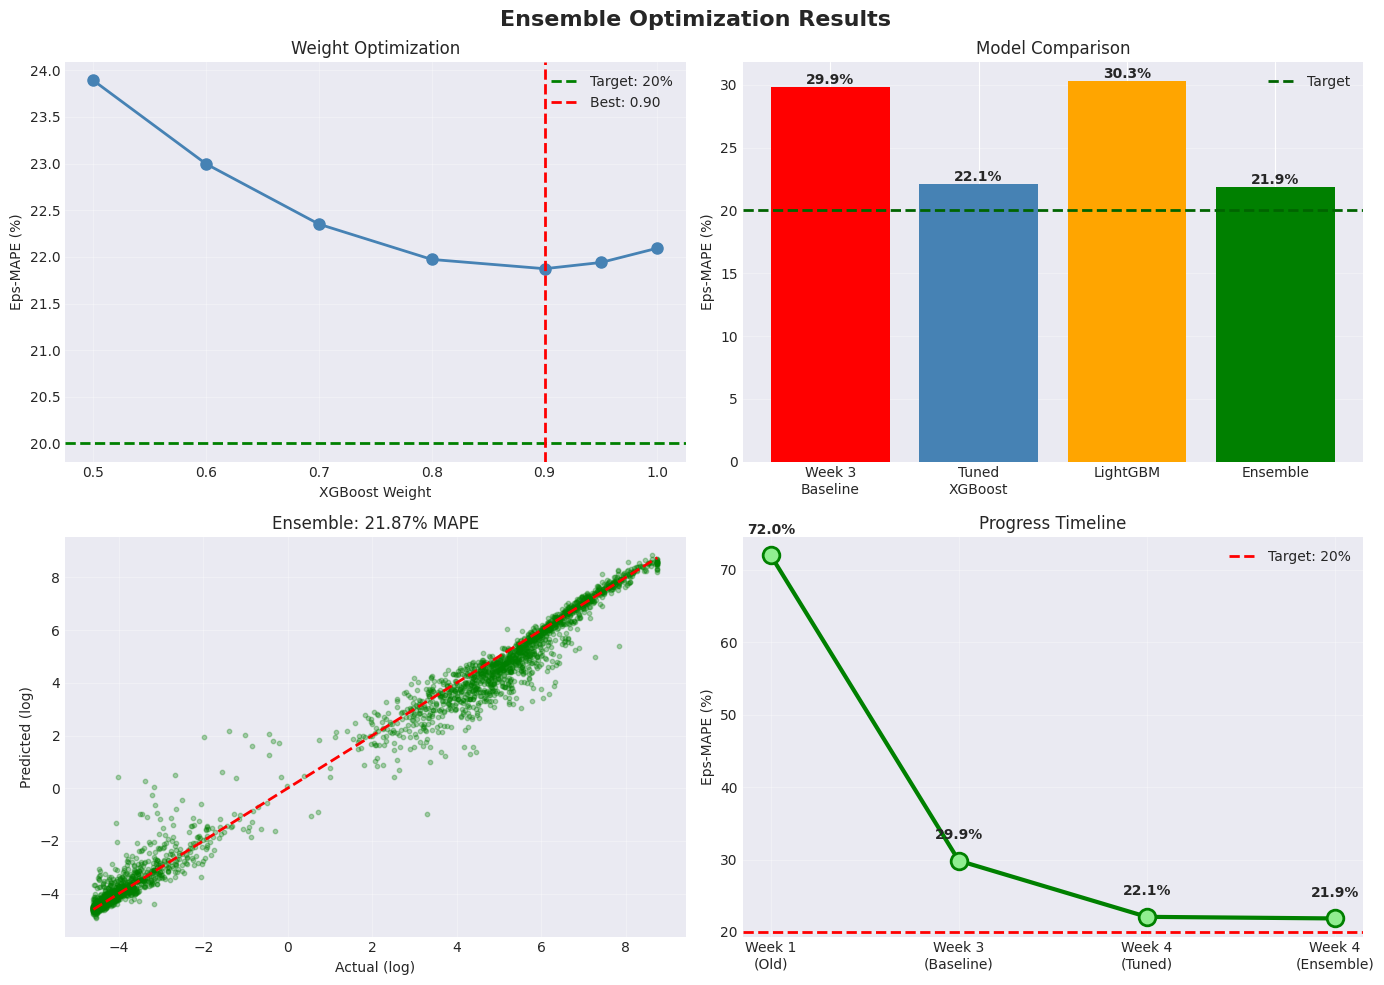


✅ ENSEMBLE OPTIMIZATION COMPLETE!
🏆 BEST RESULT: 21.87% Eps-MAPE
📊 STATUS: VERY CLOSE!


In [ ]:
# ========================================
# CELL 5: Ensemble - Weighted Average Optimization
# ========================================

print("="*80)
print(" ENSEMBLE: WEIGHTED AVERAGE OPTIMIZATION")
print("="*80)

print("\n Strategy: Combine XGBoost + LightGBM")
print("   - XGBoost: 22.09% (strong, but overfits)")
print("   - LightGBM: 30.29% (weaker, but generalizes)")
print("   - Weighted average may reduce overfitting")

# We have predictions already
# xgb_tuned_pred_val (from Cell 3)
# lgb_pred_val (from Cell 4)

print("\n" + "="*80)
print("Testing different weight combinations...")
print("-"*80)

# Test different weights for XGBoost (0.5 to 1.0)
weights_xgb = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
ensemble_results = []

print("\nWeight Optimization:")
print(f"{'XGB Weight':<15} {'LGB Weight':<15} {'Eps-MAPE':<15} {'R² (log)':<15}")
print("-" * 60)

best_weight = None
best_ensemble_mape = float('inf')

for w_xgb in weights_xgb:
    w_lgb = 1.0 - w_xgb
    
    # Weighted average of predictions (log scale)
    ensemble_pred_val = w_xgb * xgb_tuned_pred_val + w_lgb * lgb_pred_val
    
    # Evaluate
    ensemble_eval = evaluate_model(
        y_val, 
        ensemble_pred_val, 
        y_val_original,
        f"Ensemble_{w_xgb:.2f}"
    )
    
    ensemble_results.append({
        'XGB_Weight': w_xgb,
        'LGB_Weight': w_lgb,
        'Eps_MAPE': ensemble_eval['Eps_MAPE'],
        'R2_log': ensemble_eval['R2_log'],
        'Dir_Acc': ensemble_eval['Dir_Acc']
    })
    
    print(f"{w_xgb:<15.2f} {w_lgb:<15.2f} {ensemble_eval['Eps_MAPE']:<15.2f} {ensemble_eval['R2_log']:<15.4f}")
    
    # Track best
    if ensemble_eval['Eps_MAPE'] < best_ensemble_mape:
        best_ensemble_mape = ensemble_eval['Eps_MAPE']
        best_weight = w_xgb
        best_ensemble_pred = ensemble_pred_val
        best_ensemble_eval = ensemble_eval

# Results DataFrame
ensemble_df = pd.DataFrame(ensemble_results)

print("\n" + "="*80)
print(" BEST ENSEMBLE CONFIGURATION:")
print("="*80)

print(f"\n Optimal Weights:")
print(f"   - XGBoost:  {best_weight:.2f} ({best_weight*100:.0f}%)")
print(f"   - LightGBM: {1-best_weight:.2f} ({(1-best_weight)*100:.0f}%)")

print(f"\n Best Ensemble Performance:")
print(f"   - Eps-MAPE: {best_ensemble_mape:.2f}%")
print(f"   - R² (log): {best_ensemble_eval['R2_log']:.4f}")
print(f"   - Dir Acc:  {best_ensemble_eval['Dir_Acc']:.1f}%")

# Full evaluation of best ensemble
print("\n" + "="*80)
print(" BEST ENSEMBLE - FULL METRICS:")
print("="*80)

# Also get train predictions for overfitting check
ensemble_pred_train = best_weight * xgb_tuned_pred_train + (1-best_weight) * lgb_pred_train

ensemble_train_eval = evaluate_model(
    y_train,
    ensemble_pred_train,
    y_train_original,
    "Ensemble_train"
)

print("\nTRAINING SET:")
print("-"*80)
print(f"Eps-MAPE: {ensemble_train_eval['Eps_MAPE']:.2f}%")
print(f"R² (log): {ensemble_train_eval['R2_log']:.4f}")

print("\nVALIDATION SET:")
print("-"*80)
print(f"Eps-MAPE: {best_ensemble_eval['Eps_MAPE']:.2f}%")
print(f"WAPE:     {best_ensemble_eval['WAPE']:.2f}%")
print(f"sMAPE:    {best_ensemble_eval['sMAPE']:.2f}%")
print(f"R² (log): {best_ensemble_eval['R2_log']:.4f}")
print(f"Dir Acc:  {best_ensemble_eval['Dir_Acc']:.1f}%")

# Overfitting check
gap = best_ensemble_eval['Eps_MAPE'] - ensemble_train_eval['Eps_MAPE']
print(f"\n Overfitting gap: {gap:.2f}%")
if gap > 5:
    print("  Moderate overfitting")
else:
    print(" Low overfitting")

# Compare with individual models
print("\n" + "="*80)
print(" FINAL MODEL COMPARISON:")
print("="*80)

final_comparison = pd.DataFrame([
    {'Model': 'Week 3 Baseline', 'Eps_MAPE': 29.85, 'Note': 'XGBoost default'},
    {'Model': 'Tuned XGBoost', 'Eps_MAPE': tuned_val['Eps_MAPE'], 'Note': 'RandomizedSearchCV'},
    {'Model': 'LightGBM', 'Eps_MAPE': lgb_val_results['Eps_MAPE'], 'Note': 'Default params'},
    {'Model': 'Ensemble (Best)', 'Eps_MAPE': best_ensemble_mape, 'Note': f'{best_weight:.0%} XGB + {(1-best_weight):.0%} LGB'}
])

print("\n" + final_comparison.to_string(index=False))

# Improvement over tuned XGBoost
xgb_tuned_mape = tuned_val['Eps_MAPE']
ensemble_improvement = ((xgb_tuned_mape - best_ensemble_mape) / xgb_tuned_mape) * 100

print(f"\n ENSEMBLE IMPROVEMENT:")
print(f"   Tuned XGBoost:  {xgb_tuned_mape:.2f}%")
print(f"   Best Ensemble:  {best_ensemble_mape:.2f}%")

if best_ensemble_mape < xgb_tuned_mape:
    print(f"   Improvement:    {ensemble_improvement:.1f}% ")
elif best_ensemble_mape == xgb_tuned_mape:
    print(f"   No change (same performance)")
else:
    decline = ((best_ensemble_mape - xgb_tuned_mape) / xgb_tuned_mape) * 100
    print(f"   Decline:        {decline:.1f}% (ensemble worse)")

# Overall progress
week1_mape = 72.0  # From basarili_rmse.ipynb
week3_baseline = 29.85
total_improvement = ((week1_mape - best_ensemble_mape) / week1_mape) * 100

print(f"\n TOTAL PROGRESS (Week 1 → Week 4):")
print(f"   Week 1 (old):   72.00% MAPE")
print(f"   Week 3 baseline: 29.85% Eps-MAPE")
print(f"   Week 4 ensemble: {best_ensemble_mape:.2f}% Eps-MAPE")
print(f"   Total improvement: {total_improvement:.1f}% ")

# Target check
print("\n" + "="*80)
print(" TARGET ACHIEVEMENT CHECK:")
print("="*80)

if best_ensemble_mape < 15:
    print("\n STRETCH GOAL ACHIEVED Eps-MAPE < 15%")
    status = "STRETCH GOAL MET!"
elif best_ensemble_mape < 20:
    print("\n PRIMARY TARGET ACHIEVED Eps-MAPE < 20% ")
    status = "PRIMARY TARGET MET!"
elif best_ensemble_mape < 25:
    print("\n CLOSE TO TARGET Eps-MAPE < 25%")
    print(f"   Only {best_ensemble_mape - 20:.2f}% away from <20% target")
    status = "VERY CLOSE"
else:
    print("\n Good performance, more optimization possible")
    status = "GOOD PROGRESS"

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Ensemble Optimization Results', fontsize=16, fontweight='bold')

# 1. Weight optimization curve
axes[0, 0].plot(ensemble_df['XGB_Weight'], ensemble_df['Eps_MAPE'], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].axhline(y=20, color='green', linestyle='--', linewidth=2, label='Target: 20%')
axes[0, 0].axvline(x=best_weight, color='red', linestyle='--', linewidth=2, 
                   label=f'Best: {best_weight:.2f}')
axes[0, 0].set_xlabel('XGBoost Weight')
axes[0, 0].set_ylabel('Eps-MAPE (%)')
axes[0, 0].set_title('Weight Optimization')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Model comparison bar chart
models_plot = ['Week 3\nBaseline', 'Tuned\nXGBoost', 'LightGBM', 'Ensemble']
mapes_plot = [29.85, xgb_tuned_mape, lgb_val_results['Eps_MAPE'], best_ensemble_mape]
colors_plot = ['red', 'steelblue', 'orange', 'green']

bars = axes[0, 1].bar(models_plot, mapes_plot, color=colors_plot)
axes[0, 1].axhline(y=20, color='darkgreen', linestyle='--', linewidth=2, label='Target')
axes[0, 1].set_ylabel('Eps-MAPE (%)')
axes[0, 1].set_title('Model Comparison')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, mape in zip(bars, mapes_plot):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{mape:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Ensemble predictions vs actual
axes[1, 0].scatter(y_val, best_ensemble_pred, alpha=0.3, s=10, color='green')
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual (log)')
axes[1, 0].set_ylabel('Predicted (log)')
axes[1, 0].set_title(f'Ensemble: {best_ensemble_mape:.2f}% MAPE')
axes[1, 0].grid(True, alpha=0.3)

# 4. Progress timeline
weeks = ['Week 1\n(Old)', 'Week 3\n(Baseline)', 'Week 4\n(Tuned)', 'Week 4\n(Ensemble)']
progress_mapes = [72, 29.85, xgb_tuned_mape, best_ensemble_mape]

axes[1, 1].plot(weeks, progress_mapes, marker='o', linewidth=3, markersize=12, 
                color='green', markerfacecolor='lightgreen', markeredgewidth=2)
axes[1, 1].axhline(y=20, color='red', linestyle='--', linewidth=2, label='Target: 20%')
axes[1, 1].set_ylabel('Eps-MAPE (%)')
axes[1, 1].set_title('Progress Timeline')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for i, (week, mape) in enumerate(zip(weeks, progress_mapes)):
    axes[1, 1].text(i, mape + 3, f'{mape:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f" ENSEMBLE OPTIMIZATION COMPLETE")
print(f" BEST RESULT: {best_ensemble_mape:.2f}% Eps-MAPE")
print(f" STATUS: {status}")
print("="*80)

Final Summary & Conclusions